In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fh_data = pd.read_csv("framingham.csv")

def convert_to_yesno(x):
    if pd.isna(x):
        return None
    return "yes" if int(x) == 1 else "no"

categorical_vars = ["male", "currentSmoker", "BPMeds", 
                    "prevalentStroke", "prevalentHyp", 
                    "diabetes", "TenYearCHD", "education"]

continous_vars = [col for col in fh_data.columns if col not in categorical_vars]

for col in categorical_vars:
    if col == "education":
        fh_data[col] = fh_data[col].astype("category")
    else:
        fh_data[col] = fh_data[col].apply(convert_to_yesno).astype("category")
fh_data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,yes,39,4.0,no,0.0,no,no,no,no,195.0,106.0,70.0,26.97,80.0,77.0,no
1,no,46,2.0,no,0.0,no,no,no,no,250.0,121.0,81.0,28.73,95.0,76.0,no
2,yes,48,1.0,yes,20.0,no,no,no,no,245.0,127.5,80.0,25.34,75.0,70.0,no
3,no,61,3.0,yes,30.0,no,no,yes,no,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,no,46,3.0,yes,23.0,no,no,no,no,285.0,130.0,84.0,23.10,85.0,85.0,no


  0%|          | 0/1000000 [00:00<?, ?it/s]

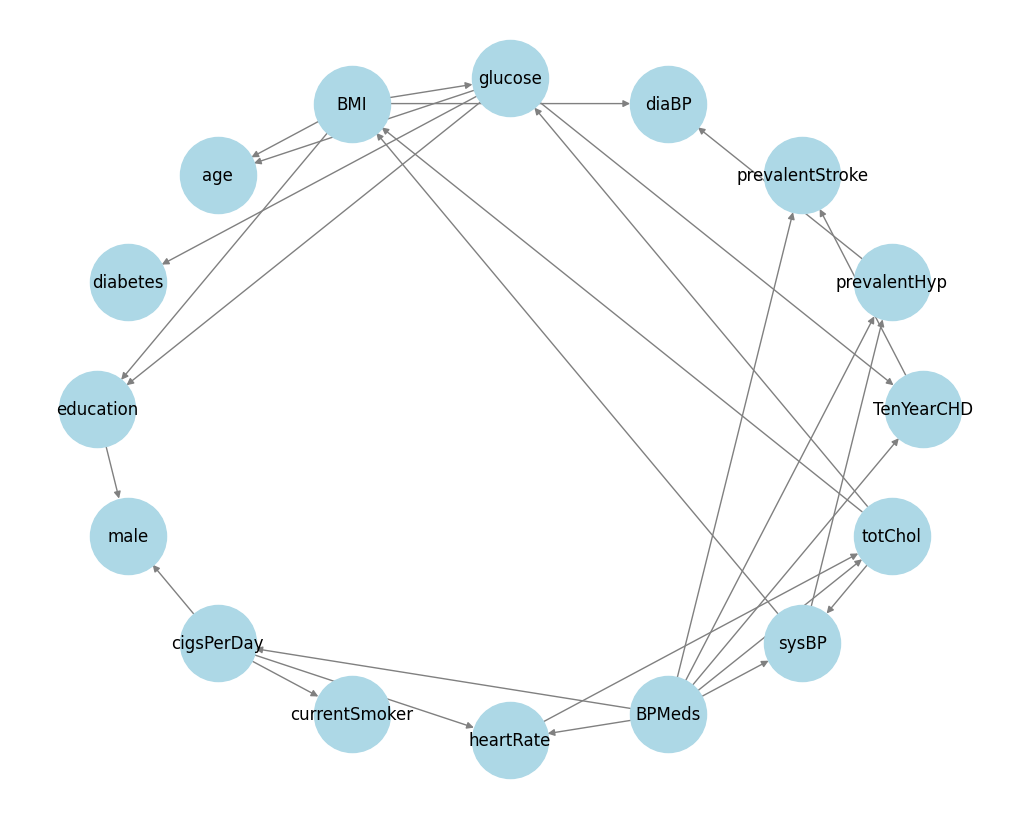

In [3]:
from pgmpy.estimators import HillClimbSearch
import networkx as nx

np.random.seed(42)
hc = HillClimbSearch(fh_data)
#k2score, bdeuscore, bicscore, bdsscore, aicscore
best_model = hc.estimate(scoring_method="k2score", max_indegree=2)

G = nx.DiGraph()
G.add_edges_from(best_model.edges())

plt.figure(figsize=(10, 8))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)
plt.show()

In [4]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

bayes_model = BayesianNetwork(best_model.edges())
bayes_model.fit(fh_data, estimator=BayesianEstimator)

In [5]:
from pgmpy.sampling import BayesianModelSampling
import logging
logging.getLogger("pgmpy").setLevel(logging.ERROR)

sampler = BayesianModelSampling(bayes_model)
synthetic_data = sampler.forward_sample(size=len(fh_data))

synthetic_data = pd.DataFrame(synthetic_data)
synthetic_data = synthetic_data[fh_data.drop(columns=set(fh_data.columns) - set(synthetic_data.columns)).columns]

obj_cols = synthetic_data.select_dtypes(include=['object']).columns
synthetic_data[obj_cols] = synthetic_data[obj_cols].apply(lambda col: col.astype('category'))
synthetic_data = synthetic_data[fh_data.drop(columns=set(fh_data.columns) - set(synthetic_data.columns)).columns]

synthetic_data.head()

  0%|          | 0/16 [00:00<?, ?it/s]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,no,38,1.0,yes,15.0,no,no,yes,no,239.0,141.0,82.0,27.80,65.0,85.0,yes
1,no,54,2.0,no,0.0,no,no,no,no,253.0,127.0,82.0,22.54,85.0,76.0,no
2,no,39,2.0,yes,20.0,no,no,no,no,196.0,124.5,79.0,28.41,78.0,73.0,no
3,no,46,1.0,no,0.0,no,no,no,no,222.0,115.0,76.0,25.46,95.0,72.0,no
4,no,62,1.0,no,0.0,no,no,yes,no,237.0,163.0,94.0,25.62,63.0,84.0,no


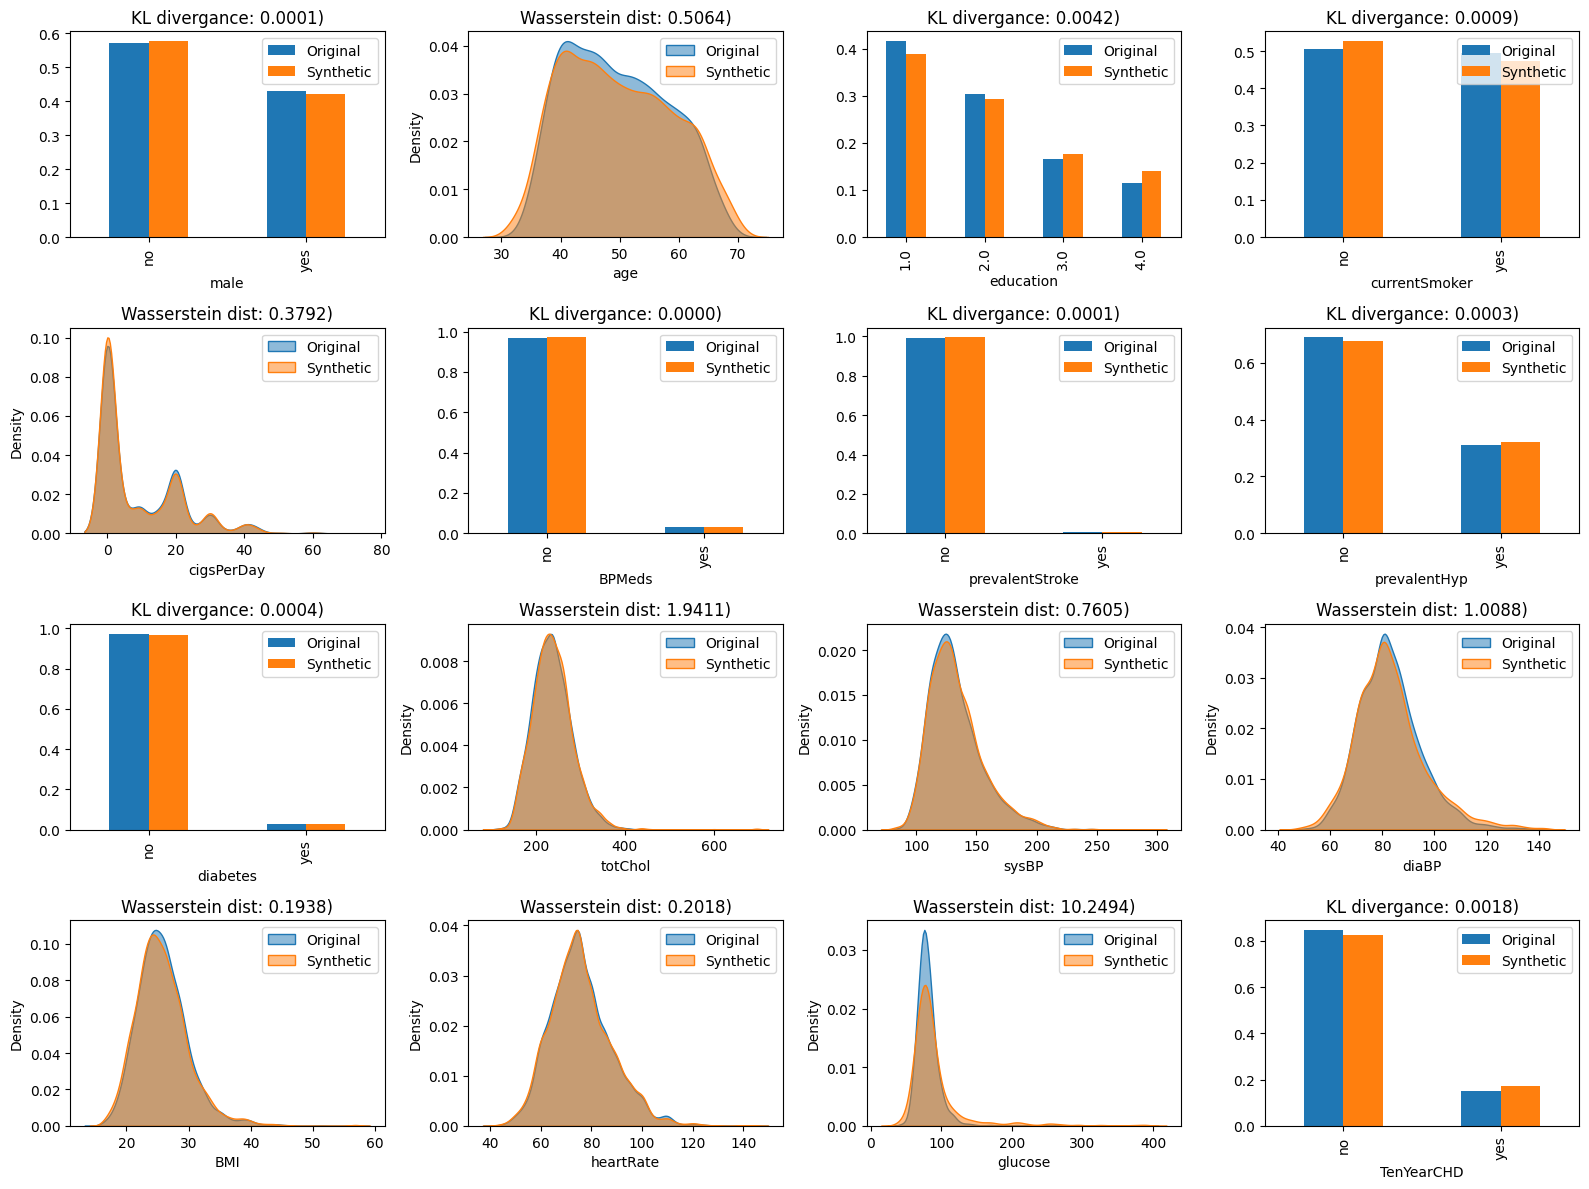

In [6]:
import math
import seaborn as sns


from scipy.stats import wasserstein_distance, entropy

def calculate_distribution_dist(original, synthetic):
    if original.dtype.kind in 'biufc':  # Continuous variable
        return wasserstein_distance(original.dropna(), synthetic.dropna())
    else:  # Categorical variable
        original_counts = original.value_counts(normalize=True)
        synthetic_counts = synthetic.value_counts(normalize=True)
        combined_counts = pd.DataFrame({'Original': original_counts, 'Synthetic': synthetic_counts}).fillna(0)
        return entropy(combined_counts['Original'], combined_counts['Synthetic'])

def plot_comparison(original_df, synthetic_df):
    # Only include variables that exist in both dataframes
    plot_vars = [var for var in original_df.columns if var in synthetic_df.columns]
    num_vars = len(plot_vars)
    
    # Determine layout dynamically
    cols = min(4, num_vars)  # Limit columns to 4 for readability
    rows = math.ceil(num_vars / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = np.array(axes).flatten()  # Ensure axes is a 1D array for easy iteration
    
    for i, var in enumerate(plot_vars):
        if original_df[var].dtype.kind in 'biufc':  # Check if numeric (continuous)
            sns.kdeplot(original_df[var], label="Original", fill=True, ax=axes[i], alpha=0.5)
            sns.kdeplot(synthetic_df[var], label="Synthetic", fill=True, ax=axes[i], alpha=0.5)
            dist = wasserstein_distance(original_df[var].dropna(), synthetic_df[var].dropna())
            axes[i].set_title(f"Wasserstein dist: {dist:.4f})")
        else:  # Categorical
            original_counts = original_df[var].value_counts(normalize=True)
            synthetic_counts = synthetic_df[var].value_counts(normalize=True)
            combined_counts = pd.DataFrame({'Original': original_counts, 'Synthetic': synthetic_counts}).fillna(0)
            combined_counts.plot(kind='bar', ax=axes[i])
            KL_divergance = entropy(combined_counts['Original'], combined_counts['Synthetic'])
            axes[i].set_title(f"KL divergance: {KL_divergance:.4f})")
            
        axes[i].legend()
    
    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_comparison(fh_data, synthetic_data)

Accuracy: 0.8597


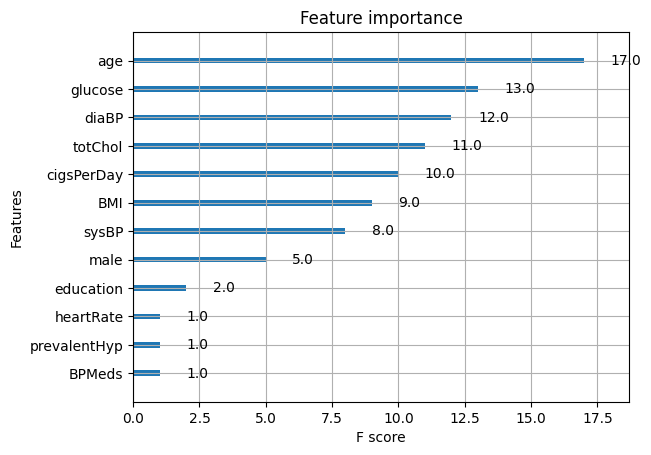

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

x = fh_data.drop(columns=["TenYearCHD"])
y = fh_data["TenYearCHD"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

model = xgb.XGBClassifier(
    enable_categorical=True,
    objective="binary:logistic", 
    eval_metric="logloss",
    seed=42,
    max_depth=5,
    gamma=5.0
)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
xgb.plot_importance(model)
plt.show()

Part Accuracy: 0.7983
Full Accuracy: 0.7814


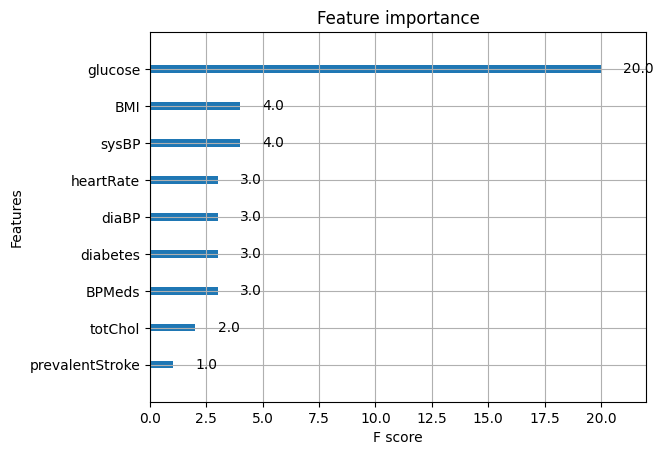

In [8]:
x = synthetic_data.drop(columns=["TenYearCHD"])
y = synthetic_data["TenYearCHD"]

x_test_full = fh_data.drop(columns=["TenYearCHD"])
y_test_full = fh_data["TenYearCHD"]

x_train, _, y_train, _ = train_test_split(x, y, test_size=0.2, random_state=42)
_, x_test_part, _, y_test_part = train_test_split(x_test_full, y_test_full, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test_full = le.transform(y_test_full)
y_test_part = le.transform(y_test_part)

model = xgb.XGBClassifier(
    enable_categorical=True,
    objective="binary:logistic", 
    eval_metric="logloss",
    seed=42,
    max_depth=5,
    gamma=5.0
)
model.fit(x_train, y_train)

y_pred = model.predict(x_test_part)
accuracy = accuracy_score(y_test_part, y_pred)
print(f"Part Accuracy: {accuracy:.4f}")

y_pred = model.predict(x_test_full)
accuracy = accuracy_score(y_test_full, y_pred)
print(f"Full Accuracy: {accuracy:.4f}")

xgb.plot_importance(model)
plt.show()

Accuracy: 0.8561


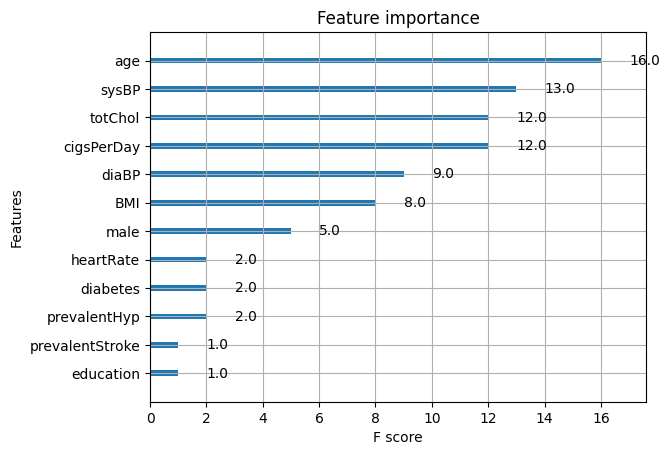

In [9]:
x = fh_data.drop(columns=["TenYearCHD","glucose"])
y = fh_data["TenYearCHD"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

model = xgb.XGBClassifier(
    enable_categorical=True,
    objective="binary:logistic", 
    eval_metric="logloss",
    seed=42,
    max_depth=5,
    gamma=5.0
)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
xgb.plot_importance(model)
plt.show()

Part Accuracy: 0.8550
Full Accuracy: 0.8479


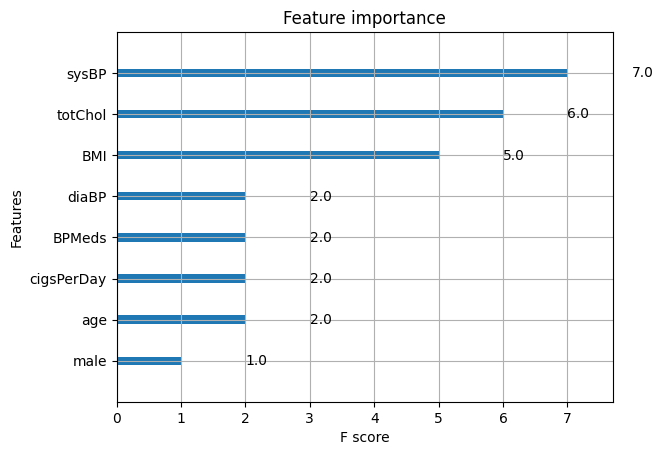

In [10]:
x = synthetic_data.drop(columns=["TenYearCHD", "glucose"])
y = synthetic_data["TenYearCHD"]

x_test_full = fh_data.drop(columns=["TenYearCHD", "glucose"])
y_test_full = fh_data["TenYearCHD"]

x_train, _, y_train, _ = train_test_split(x, y, test_size=0.2, random_state=42)
_, x_test_part, _, y_test_part = train_test_split(x_test_full, y_test_full, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test_full = le.transform(y_test_full)
y_test_part = le.transform(y_test_part)

model = xgb.XGBClassifier(
    enable_categorical=True,
    objective="binary:logistic", 
    eval_metric="logloss",
    seed=42,
    max_depth=5,
    gamma=5.0
)
model.fit(x_train, y_train)

y_pred = model.predict(x_test_part)
accuracy = accuracy_score(y_test_part, y_pred)
print(f"Part Accuracy: {accuracy:.4f}")

y_pred = model.predict(x_test_full)
accuracy = accuracy_score(y_test_full, y_pred)
print(f"Full Accuracy: {accuracy:.4f}")

xgb.plot_importance(model)
plt.show()